## From Scratch applying Bayesian Inference, Markov Chain Monte Carlo and Metropolis Hastings and MALA in python

A common technique called Markov Chain Monte Carlo commonly referred to as MCMC. The method stated is a class of techniques for sampling from a probability distribution and can be used to estimate the distribution of parameters given a set of observations.

In [21]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline

### MCMC Metropolis Hastings - Nomal distribution (function definitions and samples)
Step 1. Sample data generation  
Step 2. Formula for finding distirubtion of parameter                   
Step 3. Define PDF and Propsoal Distribution (transition model)            
Step 4. Acceptance or rejection of new parameter

In [130]:
#Transition model and proposal distribution (normal)
#The tranistion model defines how to move from sigma_current to sigma_new

#transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))[0]]
transition_model = lambda x: np.random.normal(x,[0.05,5],(2,))

def prior(w):
    #w[0] = mu, x[1]=sigma (new or current)
    #returns 1 for all valid values of sigma. Log(1) =0, so it does not affect the summation.
    #returns 0 for all invalid values of sigma (<=0). Log(0)=-infinity, and Log(negative number) is undefined.
    #It makes the new sigma infinitely unlikely.
    if(w[0]<=0 or w[1] <=0):
        return 0
    else:
        return 1

#Computes the likelihood of the data given a sigma (new or current) according to equation (2)
def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

#Same as manual_log_like_normal(x,data), but using scipy implementation. It's pretty slow.
def log_lik_normal(x,data):
    #x[0]=mu, x[1]=sigma (new or current)
    #data = the observation
    return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


#Defines whether to accept or reject the new sample
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

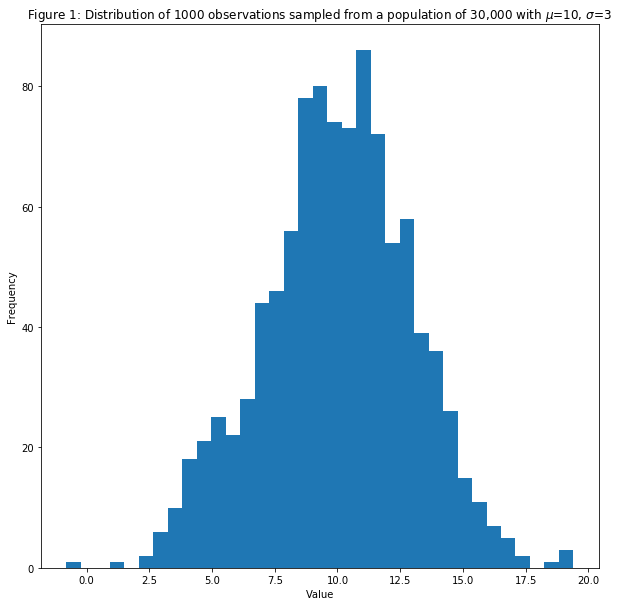

In [129]:
### emprically observed, synthically generated PDF with mu 10, sigma = 3
mod1=lambda t:np.random.normal(10,3,t) #anonymous function

#Form a population of 30,000 individual, with average=10 and scale=3
population = mod1(30000)
#Assume we are only able to observe 1,000 of these individuals.
sample_n = 5
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title("Figure 1: Distribution of 1000 observations sampled from a population of 30,000 with $\mu$=10, $\sigma$=3")
mu_obs=observation.mean()
mu_var=observation.var()

In [174]:
#accepted, rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs, mu_var], 50000,observation,acceptance)
accepted, rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[50, 5], 50000,observation,acceptance)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


Text(0.5, 1.0, '2D histogram showing the joint distribution of $\\mu$ and $\\sigma$')

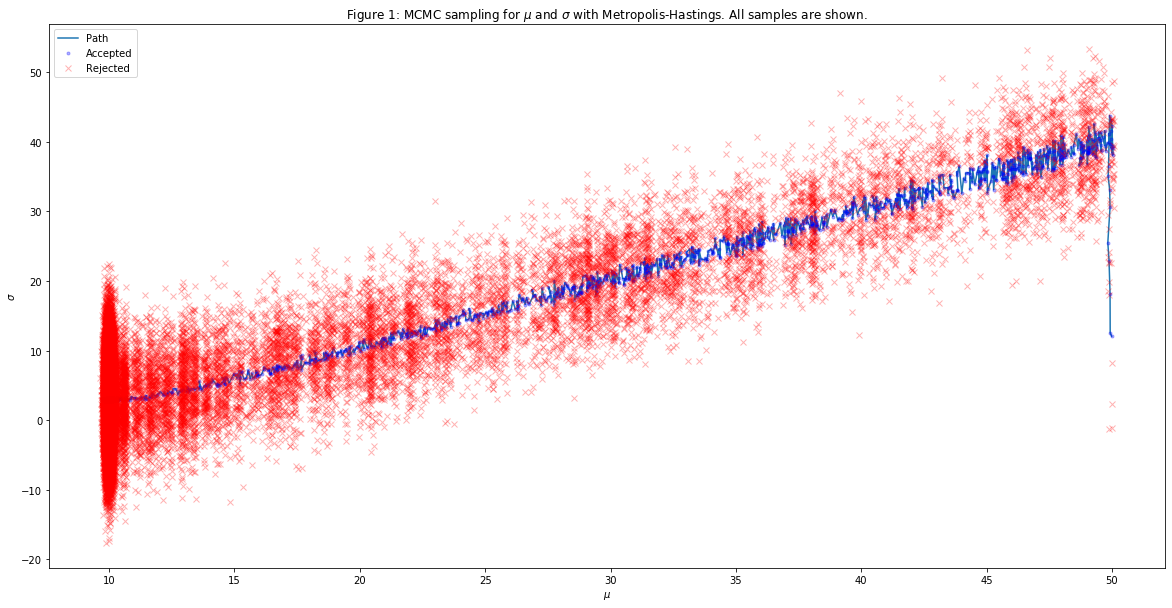

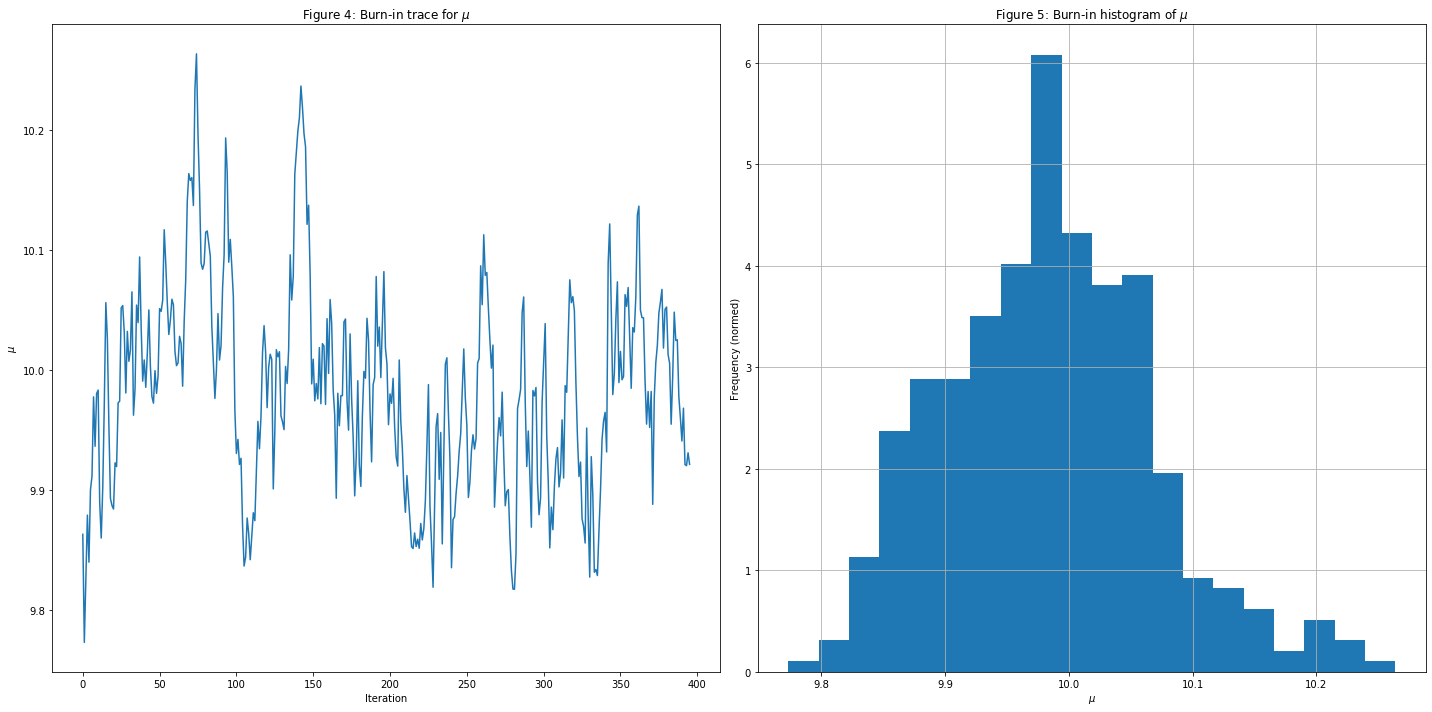

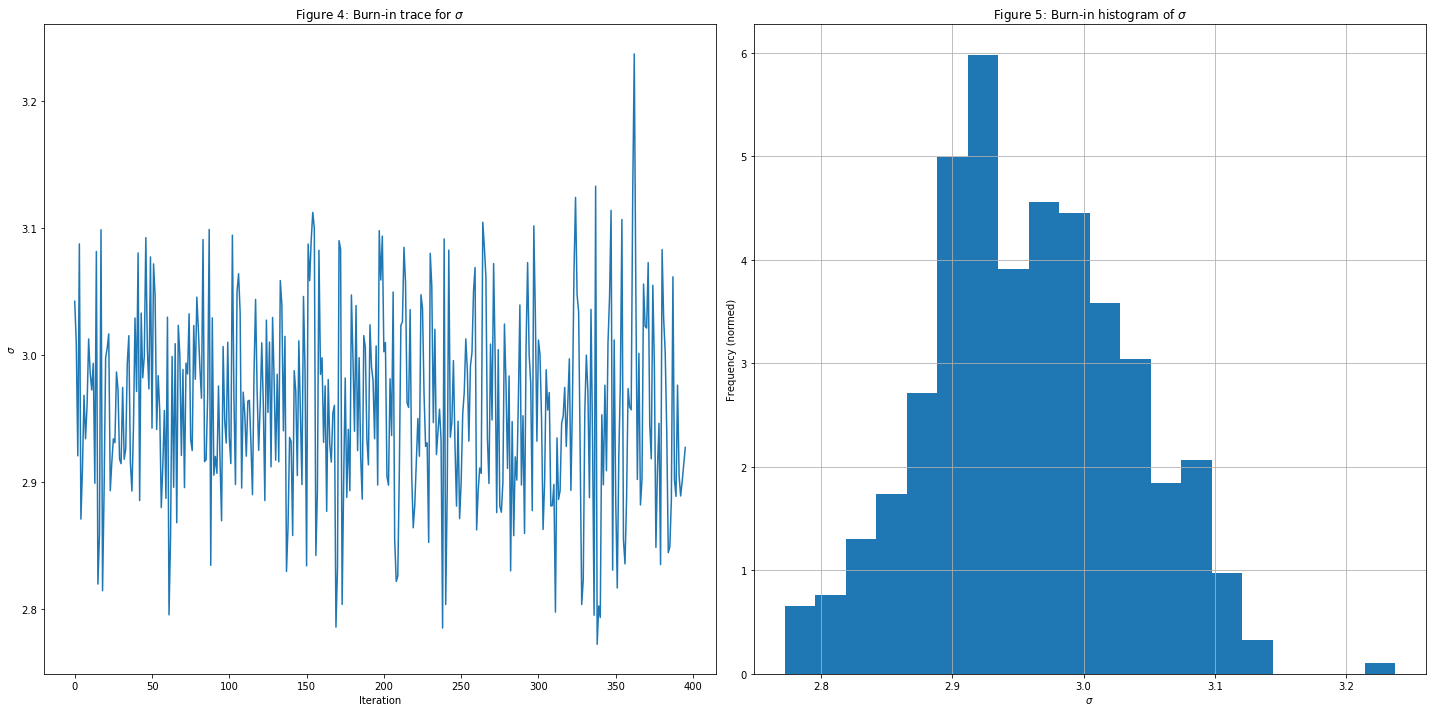

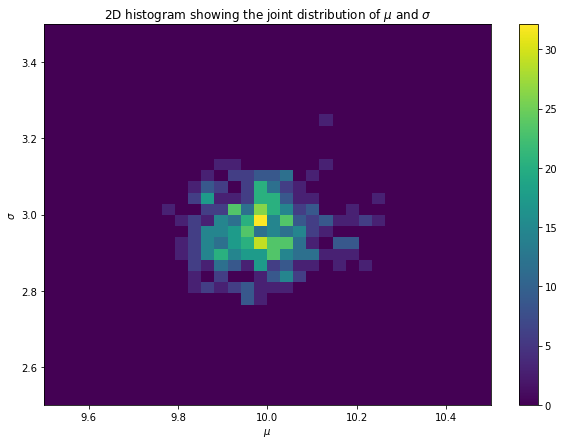

In [183]:
# full trace plot of both mu and simga
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(accepted[:,0], accepted[:,1], label="Path")
ax.plot(accepted[:,0], accepted[:,1], 'b.', label='Accepted',alpha=0.3)
ax.plot(rejected[:,0], rejected[:,1], 'rx', label='Rejected',alpha=0.3)
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\sigma$ ")
ax.legend()
ax.set_title("Figure 1: MCMC sampling for $\mu$ and $\sigma$ with Metropolis-Hastings. All samples are shown.") 


#trace plots
v=int(-0.2*accepted.shape[0])
hist_show=int(-0.2*accepted.shape[0])

#mu trace
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,0])
ax.set_title("Figure 4: Burn-in trace for $\mu$")
ax.set_ylabel("$\mu$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
#mu distribution
ax.hist(accepted[hist_show:,0], bins=20,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\mu$")
ax.set_title("Figure 5: Burn-in histogram of $\mu$")
fig.tight_layout()
ax.grid("off")

#sigma trace
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,1])
ax.set_title("Figure 4: Burn-in trace for $\sigma$")
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
#sigma distribution
ax.hist(accepted[hist_show:,1], bins=20,density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("$\sigma$")
ax.set_title("Figure 5: Burn-in histogram of $\sigma$")
fig.tight_layout()
ax.grid("off")


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
xbins, ybins = np.linspace(9.5,10.5,35), np.linspace(2.5,3.5,35)
counts, xedges, yedges, im = ax.hist2d(accepted[hist_show:,0], accepted[hist_show:,1], density=True, bins=[xbins, ybins])
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\sigma$")
fig.colorbar(im, ax=ax)
ax.set_title("2D histogram showing the joint distribution of $\mu$ and $\sigma$")

In [ ]:
mean_acc_0=accepted[show:,0].mean()
mean_acc_1=accepted[show:,1].mean()
print(mean_acc_0,mean_acc_1)

lag=np.arange(1,390)5
def autocorr(accepted,lag):
    num_0=0
    denom_0=0
    num_1=0
    denom_1=0
    for i in range(accepted.shape[0]-lag):
        num_0+=(accepted[i,0]-mean_acc_0)*(accepted[i+lag,0]-mean_acc_0)
        num_1+=(accepted[i,1]-mean_acc_1)*(accepted[i+lag,1]-mean_acc_1)
        denom_0+=(mean_acc_0-accepted[i,0])**2
        denom_1+=(mean_acc_1-accepted[i,1])**2
    rk_0=num_0/denom_0
    rk_1=num_1/denom_1
    return rk_0, rk_1


accepted_reversed=accepted[show:,:]
result=np.zeros((2,lag.shape[0]))
#print(lag)
for l in lag:
    result[:,l-1]=autocorr(accepted_reversed,l)
    
    
fig, ax = plt.subplots()
ax.plot(lag, result[1,:], label='Auto correlation for $\sigma$')
ax.plot(lag, result[0,:], label='Auto correlation for $\mu$')
ax.legend(loc=0)
ax.set_title("Figure 18: Auto-correlation for $\mu$ and $\sigma$, for k=1..390")
ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-1, 1))

### MCMC Metropolis-adjusted Langevin algorithm (MALA) - Nomal distribution (function definitions and samples)
A more involved version of the random walk used in Metropolis algorithm is the  inclusion of drift. This can be generated from the following proposal

$$ X^* = x^t + d^t + \sigma\epsilon^t , $$
where
$$ d^t = \left( \frac{\sigma^2}{2} \right) \frac{\partial log f(x)}{\partial x} \Big|_{x = x^t} $$

Step 1. Using previous Metropolis algorithm

Step 2. Update new states to include Langevin dynamics, using gradient evaluations of the gradient of the target probability density function.         

$$ Y \sim \mathcal{N}(X_n + h \frac{\nabla\pi(X_n)}{\pi(X_n)}, 2hI) $$
$$ $$
$$ \alpha(X_n, Y) = \frac{\pi(Y)}{\pi(X_n)} \exp \Big\{ \frac{1}{4h}\Big( \big|Y - X_n - h \frac{\nabla\pi(X_n)}{\pi(X_n)}\big|^2 - \big|X_n - Y - h \frac{\nabla\pi(Y)}{\pi(Y)}\big|^2 \Big) \Big\}$$
$$ $$

In [156]:
def mala(pi, grad_pi, x_0, h, n_of_steps):
    accepted = []
    rejected = []
    
    x = np.zeros((n_of_steps, x_0.size))
    x[0] = x_0
    #sumx = np.zeros(x_0.shape)
    scale = np.sqrt(2*h)
    for i in range(1, n_of_steps):
        y = np.random.normal(x[i-1]+(h/pi(x[i-1]))*grad_pi(x[i-1]), scale)
        sqsum1 = np.sum((y-x[i-1]-(h/pi(x[i-1]))*grad_pi(x[i-1]))**2)
        sqsum2 = np.sum((x[i-1]-y-(h/pi(y))*grad_pi(y))**2)
        alpha_cand = (pi(y)/pi(x[i-1])) * np.exp( (sqsum1 - sqsum2) / (4*h) )
        alpha = min(alpha_cand, 1)
        if np.random.rand() < alpha:
            x[i] = y
            accepted.append(x[i])
        else:
            x[i] = x[i-1]
            rejected.append(x[i])   
    #return x
    return np.array(accepted), np.array(rejected)

def norm(x):
    return (1/np.sqrt(2*np.pi))*np.exp(-x**2/2)

def grad_norm(x):
    return -(x/np.sqrt(2*np.pi))*np.exp(-x**2/2)

In [157]:
#mala_samples = mala(norm, grad_norm, np.array([0]), 0.01, 10**5)
accepted, rejected = mala(norm, grad_norm, np.array([0]), 0.01, 50000)

(49993, 1)

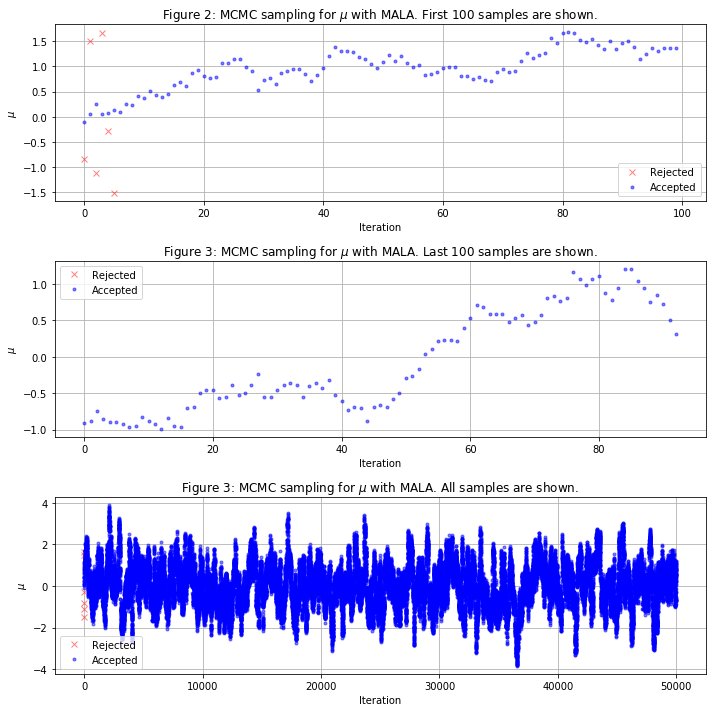

In [167]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(3,1,1)

ax.plot( rejected[0:100,0], 'rx', label='Rejected',alpha=0.5)
ax.plot( accepted[0:100,0], 'b.', label='Accepted',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\mu$")
ax.set_title("Figure 2: MCMC sampling for $\mu$ with MALA. First 100 samples are shown.")
ax.grid()
ax.legend()


to_show=-accepted.shape[0]
ax2 = fig.add_subplot(3,1,2)
ax2.plot(rejected[49900:50000,0], 'rx', label='Rejected',alpha=0.5)
ax2.plot(accepted[49900:50000,0], 'b.', label='Accepted',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\mu$")
ax2.set_title("Figure 3: MCMC sampling for $\mu$ with MALA. Last 100 samples are shown.")
ax2.grid()
ax2.legend()


to_show=-accepted.shape[0]
ax3 = fig.add_subplot(3,1,3)
ax3.plot( rejected[to_show:,0], 'rx', label='Rejected',alpha=0.5)
ax3.plot( accepted[to_show:,0], 'b.', label='Accepted',alpha=0.5)
ax3.set_xlabel("Iteration")
ax3.set_ylabel("$\mu$")
ax3.set_title("Figure 3: MCMC sampling for $\mu$ with MALA. All samples are shown.")
ax3.grid()
ax3.legend()


fig.tight_layout()
accepted.shape

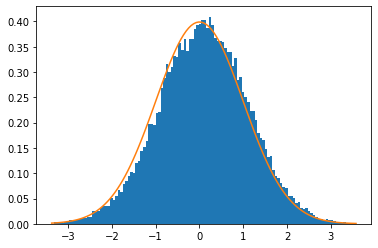

In [151]:
accepted, bins, _ = plt.hist(accepted, bins=120, density=True)
dens = np.zeros((bins.size, 1))
for i in range(dens.size):
    dens[i] = norm(bins[i])
plt.plot(bins, dens)

References:                                                   
https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo
https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm
https://en.wikipedia.org/wiki/Metropolis-adjusted_Langevin_algorithm           
Geof, H 2013, Computational Statistics, Second Edition
C:\Users\User\Desktop\git_repos\MCMC-Python